In [1]:
import tdms
import imp
imp.reload(tdms)
import plot
import functions
import numpy as np
import matplotlib
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Tail current-Voltage relationship (I-V)

In [2]:
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/D2-vc-060717-vc2-1.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702-1.tdms")
data = tdms.read_tdms("/Volumes/DATA/data/tdms/060917_Ik-060917_Ik_CELL1-31-289800657.tdms")

In [3]:
holding = -60
pulsedelay = 10
pulsedur = 200
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


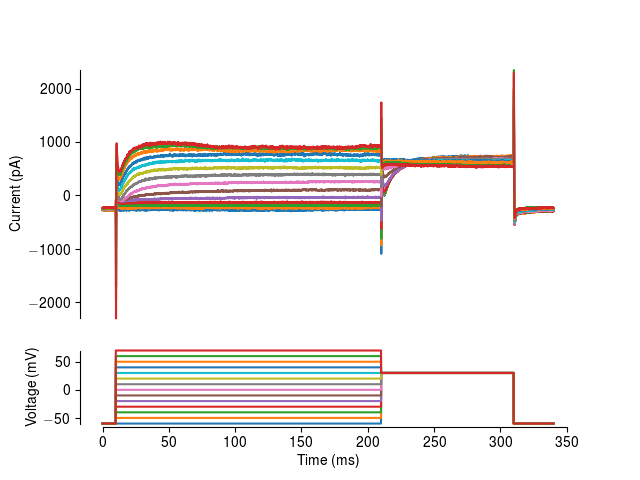

<IPython.core.display.Javascript object>


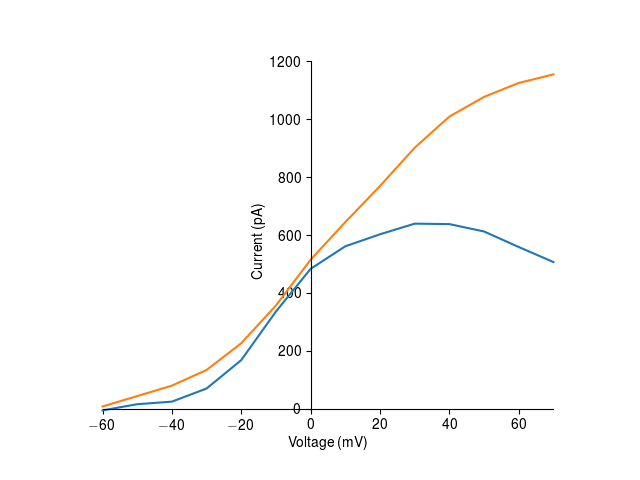

<IPython.core.display.Javascript object>


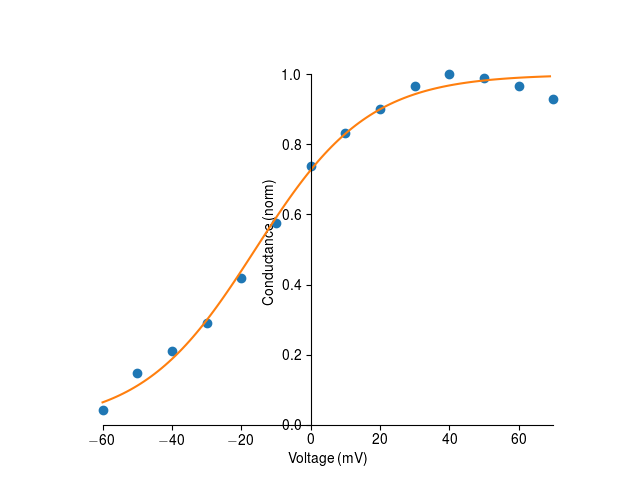

In [4]:
fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
peaks = []
steady = []
dt = data['dt']
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    pulsemin = np.min(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding
    pulses.append(pulseamp)

    baseline = np.mean(sweep[:int(pulsedelay/dt)])
    maxpeak = np.max(sweep[int((pulsedelay+pulsedur+0.75)/dt):int((pulsedelay+pulsedur+5.0)/dt)])
    minpeak = np.min(sweep[int((pulsedelay+pulsedur+0.75)/dt):int((pulsedelay+pulsedur+5.0)/dt)])
    # if np.abs(minpeak) > np.abs(maxpeak):
    peaks.append(minpeak)
    # else:
    #     peaks.append(maxpeak)
    steady.append(np.mean(sweep[
        int((pulsedelay+pulsedur-10)/dt):int((pulsedelay+pulsedur)/dt)])-baseline)
    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)

fig, ax = plot.plot_iv()
ax.plot(pulses, peaks)
ax.plot(pulses, steady)

# Plot conductance-voltage relationship
g, gfit = functions.gv(np.array(steady), np.array(pulses), -90)
curverange = np.arange(np.min(pulses), np.max(pulses), 1.0)
curve = functions.fboltz_up(gfit, curverange)

fig, ax = plot.plot_iv(ylabel="Conductance (norm)")
ax.plot(pulses, g, 'o')
ax.plot(curverange, curve)

plt.show()

# Deactivation time constant

In [27]:
data = tdms.read_tdms("/Volumes/NO NAME/L4-Ek-DM-J9-C2-Protocol1.tdms")

In [28]:
holding = -60
pulsedelay = 10
pulsedur = 200
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


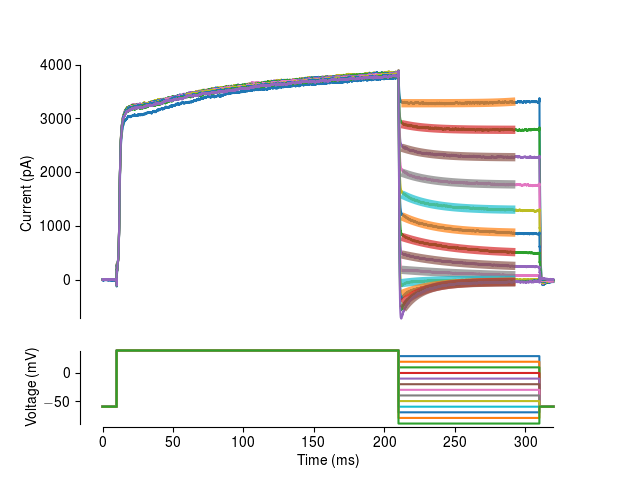

<IPython.core.display.Javascript object>


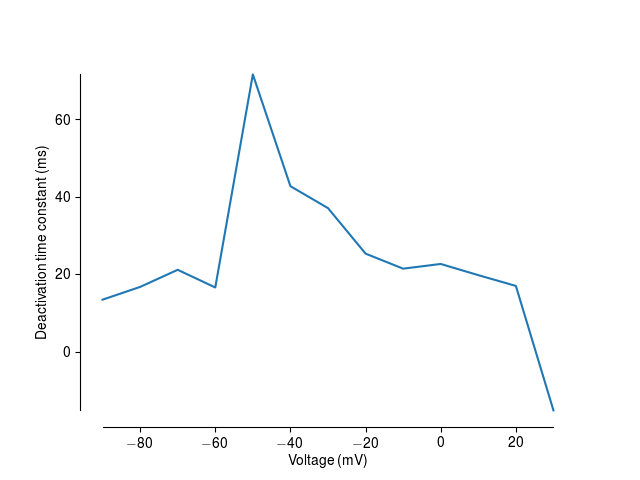

In [34]:
dt = data['dt']

ifitstart = int((pulsedelay + pulsedur + 5.0)/dt)
ifitend = int((pulsedelay + pulsedur + 80.0)/dt)

fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
taus = []
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command[
        int((pulsedelay+pulsedur+1.0)/dt):int((pulsedelay+pulsedur+10.0)/dt)]-pulsebase)
    pulsemin = np.min(command[
        int((pulsedelay+pulsedur+1.0)/dt):int((pulsedelay+pulsedur+10.0)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding

    sweepfit = sweep[ifitstart:ifitend]
    fitrange = np.arange(sweepfit.shape[0]) * dt
    if sweepfit[0] > sweepfit[-1]:
        init_amp = -10.0
    else:
        init_amp = 10.0
    taufit = functions.leastsq(
        functions.leastsq_helper, (sweepfit[-1]-sweepfit[0], 10.0, 0),
        args=(sweepfit, functions.fexp, fitrange))[0]
    plottau = functions.fexp(taufit, fitrange)
    if np.abs(taufit[1]) < 500.0:
        pulses.append(pulseamp)
        taus.append(taufit[1])

    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)
    axi.plot(fitrange+(ifitstart*dt), plottau, alpha=0.7, lw=6)

fig, ax = plot.plot_iv(ylabel=r"Deactivation time constant (ms)", zeroori=False)
ax.plot(pulses, taus)

# Frequency-current relationship (f-I)

In [34]:
data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-default-7.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-8ICLAMPSPIKES.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702iclamp-1.tdms")

In [38]:
pulsedelay = 200.0
pulsedur = 400.0
threshold = -10.0

<IPython.core.display.Javascript object>


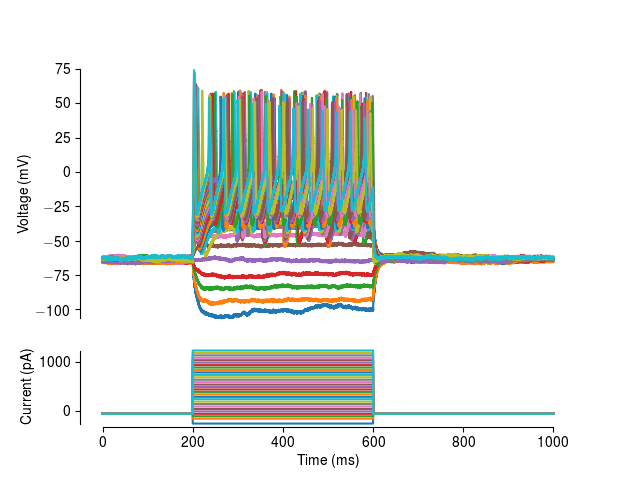

<IPython.core.display.Javascript object>


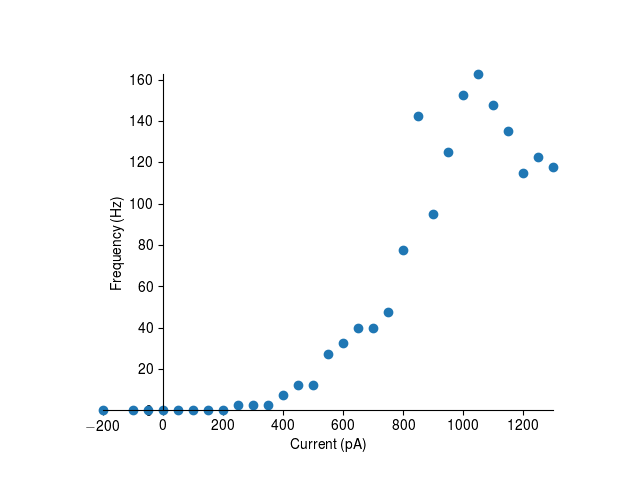

In [39]:
fig, axv, axi = plot.plot_traces(mode='cclamp')

pulses = []
fs = []
steady = []
dt = data['dt']
for sweep, command in zip(data['AI0'], data['A00']):
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command-pulsebase)
    pulsemin = np.min(command-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax
    else:
        pulseamp = pulsemin
    pulses.append(pulseamp)
    
    crossings = np.where(np.diff((sweep > threshold).astype(np.float)) == 1.0)[0]
    fs.append(1e3*len(crossings)/pulsedur)
    times = np.arange(sweep.shape[0])*data['dt']
    axv.plot(times, sweep)
    axi.plot(times, holding + command)

fig, ax = plot.plot_fi()
ax.plot(pulses, fs, 'o')
# ax.plot(pulses, steady)
plt.show()

In [16]:
from nptdms import TdmsFile

In [17]:
tdms_file = TdmsFile("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")

In [18]:
tdms_file.groups()

[u'AO0', u'AI0']

In [19]:
tdms_file.object().properties['Sampling Rate(AI)']

u'25000'

In [20]:
1.0/25000

4e-05

In [5]:
print(gfit)

[ 3.03668121  8.70758923]
